# Fama-Macbeth Cross-sectional Regressions


_If you don’t risk anything, you risk even more_ – Erica Jong

Concepts
- Portfolio Optimization, CAPM, Black-Litterman
- Tests of the CAPM, cross-sectional regression
- Polynomial regression, feature transformations, kernel trick
- Kernel regression

References
- H. M. Markowitz, “Portfolio Selection,” Journal of Finance 7, 1952, pp. 77–91.
- W. F. Sharpe, “Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk,” Journal of Finance 19, 1964, pp. 425–442. 
- J. Lintner, “Security Prices, Risk and Maximal Gains from Diversification,” Journal of Finance 20, 1965, pp. 587–615, and J. Mossin, “Equilibrium in a Capital Asset Market,” Econometrica 34, 1966, pp, 768–783. 
- Fama, Eugene F.; MacBeth, James D. (1973). "Risk, Return, and Equilibrium: Empirical Tests". Journal of Political Economy. 81 (3): 607–636.
- Black, F., and R. Litterman. 1992. “Global Portfolio Optimization.” Financial Analysts Journal, vol. 48, no. 5 (September/October): 28-43
- He, G., and R. Litterman. 1999. “The Intuition Behind Black-Litterman Model Portfolios.” Goldman Sachs Investment Management Series.
- FRM Part I Exam Book Foundations of Risk Management Ch. 5.


In [1]:
import numpy as np
from numpy import linalg as la
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.kernel_ridge import KernelRidge
import random
from tqdm import tqdm
import cvxpy as cp
from finds.database import SQL, RedisDB
from finds.structured import (BusDay, Signals, Benchmarks, CRSP,
                              CRSPBuffer, SignalsFrame)
from finds.backtesting import RiskPremium
from finds.recipes import winsorize, least_squares
from finds.readers import FFReader
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
signals = Signals(user, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
imgdir = paths['images']
LAST_DATE = bd.endmo(CRSP_DATE, -1)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Mean variance optimization

Given two investments with the same expected return (as measured by the mean of the returns), Markotwitz demonstrated that a risk-averse investor will select the one with the lowest risk (as measured by the variance). Markowitz’s theory relies on several assumption including the absence of market frictions (such as no taxes or transaction costs, perfect market competition), as well as normally distributed returns. 

The assumption of normally distributed returns implies that a “rational investor”  should evaluate potential portfolio allocations based entirely upon the associated means and variances of the return distributions. With all else being equal, investors prefer a higher mean return and a lower variance, and seek to reduce the variance of their portfolio returns by diversifying their investments with assets that whose prices do not move in lockstep with one another.

A major implementation issue with this framework comes when estimating the parameters required to apply the model (i.e., the mean and the variance of returns, along with correlations between each asset in the portfolio). These parameters are typically estimated using historical data over a certain period of time, but the resulting allocation can differ greatly depending on which historical or forecast data are used. 
There are several methodologies that have been used to deal with the problem of the uncertainty about these parameters, such as robust portfolio optimization and the Black-Litterman model.


In [4]:
# Retrieve test asset returns and risk-free rate   
symbol = '6_Portfolios_2x3'
ff = FFReader(symbol)
rf = FFReader('F-F_Research_Data_Factors')[0]['RF'] / 100  # risk-free rates
mktcaps = ff[4] * ff[5]  # number of firms x average market cap
labels = [s.replace('ME1', 'BIG').replace('ME2', 'SMALL') for s in mktcaps.columns]
n = len(labels)

In [5]:
r = (ff[0]/100).sub(rf.fillna(0), axis=0)    # excess, of the risk-free, returns
sigma = np.cov(r, rowvar=False)
mu = np.mean(r, axis=0).values
assets = DataFrame(data={'mean': mu, 'volatility': np.sqrt(np.diag(sigma))}, index=labels)

In [6]:
mkt = {'weights': (mktcaps.iloc[-1]/mktcaps.iloc[-1].sum()).values}  # latest caps
mkt['mean'] = mkt['weights'].dot(mu)
mkt['variance'] = mkt['weights'].dot(sigma).dot(mkt['weights'])
pd.concat([assets.T, Series({'mean': mkt['mean'], 'volatility': np.sqrt(mkt['variance'])},
                            name='Mkt')], axis=1)

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM,Mkt
mean,0.007035,0.009628,0.011497,0.006759,0.006898,0.009195,0.007051
volatility,0.074820,0.069733,0.081141,0.053040,0.056313,0.071363,0.053834


### Global minimum variance portfolio

Given estimates of assets' variances and their correlations with each other, the Global Minimum Variance (GMV) portolio identifies the allocation that achieves the lowest risk (and ignores mean returns).  It is a convex (quadratic) optimization problem, with constraint that the portfolio weights must sum to 1. The Python package conveniently solves such problems numerically: $\min_w w^T \Sigma w$, such that $w^T 1 = 1$. 

In [7]:
W = cp.Variable(n)   # variable to optimize over - portfolio weights
Var = cp.quad_form(W, sigma)    # objective to minimize portfolio volatility
Ret = mu.T @ W                  # objective to maximize portfolio return

In [8]:
obj = cp.Problem(cp.Minimize(Var), [cp.sum(W) == 1])
obj.solve()
gmv = dict(weights=W.value, variance=Var.value, mean=Ret.value,
              coords=(np.sqrt(Var.value), Ret.value))

The GMV portfolio weights can also be derived in closed form solution by differentiating the (convex) objective function and setting the FOC to zero: GMV $= \dfrac{\Sigma^{-1} 1}{1^T \Sigma^{-1} 1}$



In [9]:
def gmv_portfolio(sigma, mu=None):
    """Returns position weights of global minimum variance portfolio"""
    ones = np.ones((sigma.shape[0], 1))
    w = la.inv(sigma).dot(ones) / ones.T.dot(la.inv(sigma)).dot(ones)
    return {'weights': w, 'volatility': np.sqrt(w.T.dot(sigma).dot(w)),
            'mean': None if mu is None else w.T.dot(mu)}

In [10]:
w = gmv_portfolio(mu=mu, sigma=sigma)['weights']
pd.concat([Series(gmv['weights']).rename('numerical'),
           Series(w.flatten()).rename('formula')], axis=1)\
  .set_index(assets.index).T

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
numerical,-0.487434,0.674154,-0.332693,0.789665,0.830716,-0.474408
formula,-0.487434,0.674154,-0.332693,0.789665,0.830716,-0.474408


### Efficient frontier

Each point on the efficient frontier curve represents the portfolio of risky assets that is expected to offer the highest return for the given level of risk as measured by the standard deviation of returns $\sigma$. A line is drawn from the risk-free rate becomes tangent to the efficient frontier at the point called the __tangency portfolio__.  Portfolios that lie on this line, called the __capital market line__, given by $E(R_p) = r_f + \dfrac{E[R_M] - r_f}{\sigma_M} \sigma_p$, dominate all portfolios on the efficient frontier.  In other words, a tangency portfolio is a portfolio that lies at the point where the efficient frontier is tangent to the highest possible capital market line (CML) in the risk-return space. 
The implication of the Capital Market Line is that all investors should allocate to the risk-free asset and the tangency market portfolio. This is called the __two fund separation theorem__.

In [11]:
var_ticks = np.linspace(gmv['variance'], 3*np.max(np.diag(sigma)), 200)
best_slope, tangency = 0, tuple()    # to find the tangency portfolio
efficient = []
for var in var_ticks:
    obj = cp.Problem(cp.Maximize(Ret), [cp.sum(W) == 1, Var <= var])
    obj.solve(verbose=False)

    # tangency portfolio has best slope
    risk = np.sqrt(var)
    slope = Ret.value / risk
    if slope > best_slope:
        best_slope = slope
        tangency = {'coords': (risk, Ret.value), 'weights': W.value}
    efficient.append(dict(mean=Ret.value, volatility=risk))

In [12]:
frontier = []     # inefficient frontier
for var in var_ticks:
    obj = cp.Problem(cp.Minimize(Ret), [cp.sum(W) == 1, Var <= var])
    obj.solve(verbose=False)
    frontier.append(dict(mean=Ret.value, volatility=np.sqrt(var)))

The efficient and tangency portfolios can also be solved with closed form solutions.

- Efficient portfolio (target return $\mu_0$) = $\Sigma^{-1} M (M^T \Sigma^{-1} M)^{-1} [\mu_0 \ 1]^T$, where $M=[\mu \ 1]$

- Tangency portfolio = $\dfrac{\Sigma^{-1} \mu}{1^T \Sigma ^{-1} \mu}$

Furthermore, any portfolio on the efficient frontier is a linear combination of any two other efficient portfolios.


In [13]:
def efficient_portfolio(mu, sigma, target):
    """Returns weights of minimum variance portfolio that exceeds target return"""
    mu = mu.flatten()
    n = len(mu)
    ones = np.ones((n, 1))
    M = np.hstack([mu.reshape(-1, 1), ones])
    B = M.T.dot(la.inv(sigma)).dot(M)
    w = la.inv(sigma).dot(M).dot(la.inv(B)).dot(np.array([[target], [1]]))
    return {'weights': w, 'volatility': np.sqrt(float(w.T.dot(sigma).dot(w))),
            'mean': float(w.T.dot(mu))}

In [14]:
p = random.choice(efficient)
e = efficient_portfolio(mu,sigma, p['mean'])
df = DataFrame({'random efficient portfolio': p,
                'by formula': dict(mean=e['mean'], volatility=e['volatility'])})

/tmp/ipykernel_3511161/3388186085.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {'weights': w, 'volatility': np.sqrt(float(w.T.dot(sigma).dot(w))),
/tmp/ipykernel_3511161/3388186085.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'mean': float(w.T.dot(mu))}


In [15]:
def tangency_portfolio(mu, sigma):
    """Returns weights of tangency portfolio with largest slope (sharpe ratio)"""
    mu = mu.flatten()
    n = len(mu)
    ones = np.ones((n, 1))
    w = la.inv(sigma).dot(mu)/ones.T.dot(la.inv(sigma).dot(mu))
    return {'weights': w, 'mean': float(w.T.dot(mu)),
            'volatility': np.sqrt(float(w.T.dot(sigma).dot(w)))}

In [16]:
s = tangency_portfolio(mu, sigma)

In [17]:
# show numerical and formulas are same solution
DataFrame({'tangency portfolio': list(tangency['coords']),
           'tangency formula': [s['volatility'], s['mean']]},
          index=['volatility', 'mean']).join(df)

,tangency portfolio,tangency formula,random efficient portfolio,by formula
volatility,0.081199,0.081108,0.137064,0.137064
mean,0.017051,0.017031,0.027701,0.027701


Plot efficient frontier and portfolios

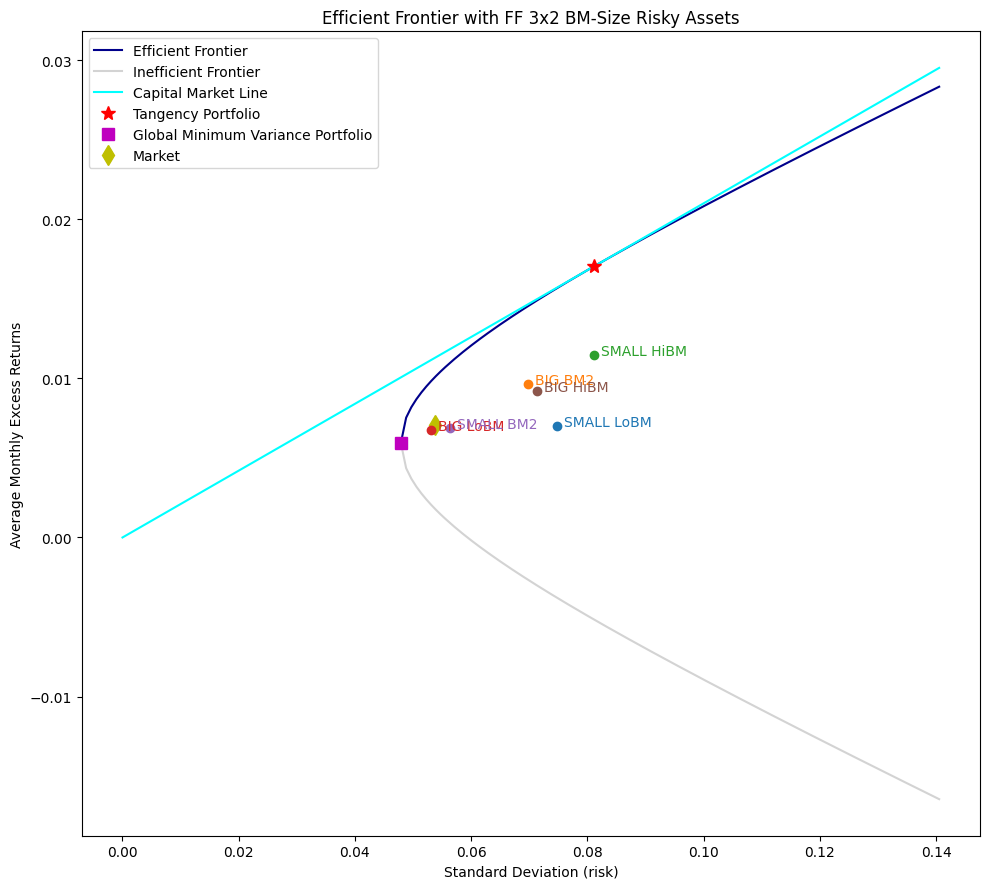

In [18]:
fig, ax = plt.subplots(figsize=(10, 9))
DataFrame(efficient).set_index('volatility').plot(ax=ax, color='darkblue')
DataFrame(frontier).set_index('volatility').plot(ax=ax, color='lightgrey')
ax.plot([0, np.sqrt(max(var_ticks))], [0, np.sqrt(max(var_ticks))*best_slope],
        color='cyan')  # capital market line
ax.plot(*tangency['coords'], "r*", ms=10)                    # tangency portfolio
ax.plot(np.sqrt(gmv['variance']), gmv['mean'], "ms", ms=8)   # GMV portfolio
ax.plot(np.sqrt(mkt['variance']), mkt['mean'], "yd", ms=10)  # market portfolio
plt.legend(['Efficient Frontier', 'Inefficient Frontier', 'Capital Market Line',
            'Tangency Portfolio', 'Global Minimum Variance Portfolio', 'Market'])
for c, r in enumerate(assets.itertuples()):   # risky assets
    ax.plot(r.volatility, r.mean, marker='o', color=f"C{c}")
    ax.annotate(text=r.Index, xy=(r.volatility, r.mean),
                xytext=(0.5, 0), textcoords="offset fontsize", color=f"C{c}")
ax.set_xlabel('Standard Deviation (risk)')
ax.set_ylabel('Average Monthly Excess Returns')
ax.set_title('Efficient Frontier with FF 3x2 BM-Size Risky Assets')
plt.tight_layout()

### CAPM

Sharpe, Lintner, and Mossin derived an equilibrium model showing the relationship between the risk and expected return of a risky asset.

The derivation of CAPM includes several crucial assumptions, some of which are the same as those used by Markowitz.
The CAPM model shows that market equilibrium is achieved when all investors hold portfolios consisting of the riskless asset and the market portfolio described earlier. Each investor’s portfolio is just a combination of these two, with the proportional allocation between them being a function of the individual investor’s risk appetite. Accordingly, the expected return on a risky asset is deter-mined by that asset’s relative contribution to the market portfolio’s total risk. In this case, the relevant measure of risk is the risk that cannot be diversified away (i.e., non-diversifiable risk or systematic risk). This means that investors should only be compensated for the risk that cannot be eliminated by diversification.

Specifically, the total risk of a risky asset is decomposed into two components -- a systematic component proxied by the asset's beta $\beta_i = \dfrac{cov(R_i, R_M)}{var(R_M)}$, and a idiosyncratic component that can be diversified away. 

The __security market line__ gives the relationship between the expected return for individual assets and risk as proxied by beta $E(R_i) = r_f + \beta_i (E[R_M] - r_f)$.


## Implied alphas

If some portfolio allocation $W$ is known to be solution of some mean-variance objective above, then we can infer the mean returns input if given the covariance matrix. In other words, these __implied alphas__, which are proportional to $w^T \Sigma$, when input as the mean returns vector along with the same covariance matrix, delivers $W$ as the mean-variance optimization solution.


In [19]:
# market cap-weighted portfolio implied expected returns
capm = mkt['weights'].dot(sigma) * 2

In [20]:
# HML implied alphas
hml = Series(0.0, index=assets.index)
hml['BIG HiBM'] = 0.5
hml['SMALL HiBM'] = 0.5
hml['BIG LoBM'] = -0.5
hml['SMALL LoBM'] = -0.5
#hml = {'weights': hml.values}
#hml['variance'] = hml['weights'].dot(sigma).dot(hml['weights'])
#hml['coords'] = (np.sqrt(hml['variance']), hml['weights'].dot(mu))
alphas = hml.dot(sigma) * 2

In [21]:
pd.concat([Series(hml.values).rename('HML weights'),
           Series(alphas).rename('HML implied-alpha'),
           Series(mkt['weights']).rename('Market weights'),
           Series(capm).rename('CAPM equilibrium returns'),
           Series(mu).rename('historical mu'),
           Series(Series(alphas)/Series(capm)).rename('implied/capm')],
          axis=1, ignore_index=False)\
  .set_index(assets.index).T

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
HML weights,-0.500000,0.000000,0.500000,-0.500000,0.000000,0.500000
HML implied-alpha,0.000737,0.001824,0.003134,0.000284,0.001637,0.002977
Market weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
CAPM equilibrium returns,0.007052,0.006732,0.007457,0.005625,0.005780,0.006901
historical mu,0.007035,0.009628,0.011497,0.006759,0.006898,0.009195
implied/capm,0.104457,0.270983,0.420304,0.050527,0.283150,0.431309


In [22]:
# Correlations of alphas
DataFrame({'historical mu': np.corrcoef(alphas, mu)[0][-1],
           'capm equilbrium': np.corrcoef(alphas, capm)[0][-1]},
          index=['Correlation with implied alphas'])

,historical mu,capm equilbrium
Correlation with implied alphas,0.841491,0.625979


In [23]:
# Mean-variance optimization with HML-implied alphas
MeanVariance = alphas @ W - Var    
obj = cp.Problem(cp.Maximize(MeanVariance))
obj.solve(verbose=False)
DataFrame.from_records([hml.values, W.value], columns=labels,
                       index=['HML weights', 'mean-variance weights']).round(6)

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
HML weights,-0.5,0.0,0.5,-0.5,0.0,0.5
mean-variance weights,-0.5,-0.0,0.5,-0.5,-0.0,0.5


In [24]:
# Mean-variance optimization with CAPM-implied expected returns
MeanVariance = capm @ W - Var
obj = cp.Problem(cp.Maximize(MeanVariance))
obj.solve(verbose=False)
p = tangency_portfolio(mu=capm, sigma=sigma)
DataFrame.from_records([W.value, mkt['weights'], p['weights']], columns=labels,
                       index=['Market weights', 'mean-variance weights', 'formula'])

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Market weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
mean-variance weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
formula,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135


### Black-Litterman Model
Mean-variance efficient portfolios are highly sensitive to the inputs. Errors in estimating expected returns are observed to many times more important than errors in estimating variances and covariances.  Black and Litterman (1992) suggest that "shrinking" investors' views towards the expected returns implied by the market portfolio can deliver portfolio allocations that are less sensitive to parameter uncertainty.

In [25]:
active = tangency['weights'] - mkt['weights']
DataFrame.from_records([tangency['weights'], mkt['weights'], active], columns=labels,
                       index=['Tangency Portfolio Weights', 'Market Weights',
                              'Active Weights']).round(6)

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Tangency Portfolio Weights,-2.890459,2.793973,0.988490,2.065088,-1.374475,-0.582617
Market Weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
Active Weights,-2.900814,2.775702,0.975409,1.408571,-1.618116,-0.640752


Black-Littermn alphas are computed as:

$E[R] = [(\tau\Sigma)^{-1} + P^T \Omega^{-1} P]^{-1} [(\tau\Sigma)^{-1}\Pi + P^T \Omega^{-1} Q]$

- $\tau$ is a non-negative scalar that reflects an overall level of confidence in the active views versus the equilibrium expected returns. It effectively determines the overall weight placed on the active views relative to the equilibrium expected returns
- In Bayesian terms, $\tau$ measures the subjective degree of uncertainty as to how
precisely the equilibrium returns (the expected return priors) have been estimated


In [26]:
tau = 0.05  # He and Litterman (1992) for a moderate amount of active risk
k = 1
Pi = capm.reshape((n, 1))          # equilbrium views: CAPM implied excess returns
P = (tangency['weights']).reshape((k, n))          # view portfolio weights
Q = (tangency['weights'].dot(mu)).reshape((k, k))  # portfolio view
Omega = np.diag(np.array(P.dot(sigma).dot(P.T)).reshape((k,k))) # uncertainty

In [27]:
def black_litterman(tau, Pi, Sigma, P, Q):
    """Returns black-litterman alphas"""
    def inv(x):
        """helper wraps over la.inv to handle scalar/1d inputs"""
        try:
            return la.inv(x)
        except:
            return np.array(1/x).reshape((1,1))
    return inv(inv(tau*Sigma)+P.T.dot(inv(Omega)).dot(P))\
        .dot(inv(tau*Sigma).dot(Pi) + P.T.dot(inv(Omega)).dot(Q))

In [28]:
bl = {'alphas': black_litterman(tau=tau, Pi=Pi, Sigma=sigma, P=P, Q=Q)}
bl |= tangency_portfolio(mu=bl['alphas'], sigma=sigma)
bl['mean'] = bl['weights'].dot(mu)    # express mean based on original mu
bl['tilt'] = bl['weights'] - mkt['weights']
print('Active Risk:', np.sqrt(bl['tilt'].T.dot(sigma).dot(bl['tilt'])))
DataFrame.from_dict({'Black-Litterman weights': bl['weights'], 
                     'Market weights': mkt['weights'], 'Active weights': bl['tilt']},
                     columns=labels, orient='index').round(6)

Active Risk: 0.0025567237847205545


,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Black-Litterman weights,-0.106291,0.129886,0.052304,0.713158,0.178574,0.032369
Market weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
Active weights,-0.116646,0.111615,0.039223,0.056641,-0.065067,-0.025765


In [29]:
# BL tilts the optimal weights towards the active positions in the view portfolio
bl['tilt'] / active

array([0.04021136, 0.04021136, 0.04021136, 0.04021136, 0.04021136,
       0.04021136])

Alternatively, it is also possible, with numerical solvers such as cvxpy, to impose constraints such as no short-sales, and then iteratively add more constraints such that optimization solution "look" more reasonable.

In [30]:
Alpha = W @ mu

In [31]:
# Minimize variance to same expected return
obj = cp.Problem(cp.Minimize(Var), [cp.sum(W) == 1, W >= 0, Alpha >= bl['mean']])
obj.solve()
tilt = W.value - mkt['weights']
print('Minimize variance to achieve target return, with no short sales:')
print('Active Risk:', np.sqrt(tilt.T.dot(sigma).dot(tilt)))
DataFrame.from_dict({'Constrained weights': W.value,
                     'Market weights': mkt['weights'], 'Active weights': tilt},
                     columns=labels, orient='index').round(6)

Minimize variance to achieve target return, with no short sales:
Active Risk: 0.004234890777233881


,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Constrained weights,0.000010,0.011640,0.136556,0.745308,0.106486,-0.000002
Market weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
Active weights,-0.010344,-0.006631,0.123475,0.088791,-0.137154,-0.058137


In [32]:
obj = cp.Problem(cp.Maximize(Alpha),
                 [cp.sum(W) == 1, W >= 0, Var <= bl['volatility']**2])
obj.solve()
tilt = W.value - mkt['weights']
print('Maximize return within target variance, with no short sales:')
print('Active Risk (annualized):', np.sqrt(tilt.T.dot(sigma).dot(tilt) * 12))
DataFrame.from_dict({'Constrained weights': W.value,
                     'Market weights': mkt['weights'], 'Active weights': tilt},
                     columns=labels, orient='index').round(6)

Maximize return within target variance, with no short sales:
Active Risk (annualized): 0.008422533939240117


/home/terence/env3.11/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Constrained weights,0.000000,0.025048,0.055445,0.737171,0.182336,0.000000
Market weights,0.010355,0.018271,0.013081,0.656517,0.243641,0.058135
Active weights,-0.010355,0.006777,0.042364,0.080654,-0.061305,-0.058135


## Cross-sectional regressions

The Fama-MacBeth (1973) method estimates the betas and risk premia for any risk factors that are expected to determine asset prices. The parameters are estimated in two steps:

- First regress each time series of asset returns against proposed risk factor returns to determine each asset's beta exposures.

- Then regress all asset returns for each of T time periods against the previously estimated betas to determine the average risk premium for each factor.

This provides standard errors that are corrected for cross-sectional correlation effects.


### Testing the CAPM


Retrieve test asset returns and risk-free rate.  In addition to testing whether the "beta" is priced (i.e. that higher beta assets achieve linearly larger risk premiums than lower beta assets), we also test for non-linearity affects by including a beta-squared factor, and (supposedly) non-priced factors such as the residual riskiness of the assets.

In [33]:
factors = FFReader('F-F_Research_Data_Factors')[0] / 100  # risk-free rates
test_assets = FFReader('25_Portfolios_ME_BETA_5x5')
df = test_assets[1] / 100
df = df.sub(factors['RF'], axis=0).dropna().copy()

In [34]:
# unpivot the wide table to a long one
rets = df.stack()\
         .reset_index(name='ret')\
         .rename(columns={'level_1':'port', 'level_0':'Date'})

In [35]:
# estimate test assets' market betas from their time-series of returns
data = df.join(factors[['Mkt-RF']], how='left')
betas = least_squares(data, y=df.columns, x=['Mkt-RF'], stdres=True)
betas = betas.rename(columns={'Mkt-RF': 'BETA'})[['BETA', '_stdres']]

In [36]:
# collect test asset mean returns and betas
assets_df = betas[['BETA']].join(df.mean().rename('premiums')).sort_values('BETA')

In [37]:
# Orthogonalize polynomial (quadratic) beta^2 and residual-volatility features
betas['BETA2'] = smf.ols("I(BETA**2) ~ BETA",  data=betas).fit().resid
betas['RES'] = smf.ols("_stdres ~ BETA + BETA2", data=betas).fit().resid
r = rets.join(betas, on='port').sort_values(['port', 'Date'], ignore_index=True)

In [38]:
# run monthly Fama-MacBeth cross-sectional regressions
fm = r.groupby(by='Date')\
      .apply(least_squares, y=['ret'], x=['BETA', 'BETA2', 'RES'])

/tmp/ipykernel_3511161/3663017786.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(least_squares, y=['ret'], x=['BETA', 'BETA2', 'RES'])


In [39]:
# compute time-series means and standard errors of the Fama-MacBeth coefficients
out = DataFrame(dict(mean=fm.mean(), stderr=fm.sem(), tstat=fm.mean()/fm.sem())).T

In [40]:
print("Monthly Cross-sectional Regressions" +
      f"{min(rets['Date'])} to {max(rets['Date'])}")
out

Monthly Cross-sectional Regressions1963-07 to 2024-04


,_intercept,BETA,BETA2,RES
mean,0.007872,0.000024,-0.008729,0.123100
stderr,0.001545,0.002274,0.002568,0.060929
tstat,5.095392,0.010539,-3.399499,2.020381


__Clustered standard errors__

Alternative methods of correcting standard errors for time series and cross-sectional correlation in the error term may look into double clustering by firm and year.

In [41]:
### Compare uncorrected to robust cov
ls = smf.ols("ret ~ BETA + BETA2 + RES", data=r).fit()
print(ls.summary())
# print(ls.get_robustcov_results('HC0').summary())
# print(ls.get_robustcov_results('HAC', maxlags=6).summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.622
Date:                Sat, 29 Jun 2024   Prob (F-statistic):             0.0489
Time:                        11:10:51   Log-Likelihood:                 25431.
No. Observations:               18250   AIC:                        -5.085e+04
Df Residuals:                   18246   BIC:                        -5.082e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0079      0.002      4.178      0.0

In [42]:
print(ls.get_robustcov_results('hac-panel',
                               groups=r['port'],
                               maxlags=6).summary())
# print(ls.get_robustcov_results('cluster', groups=r['port']).summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.667
Date:                Sat, 29 Jun 2024   Prob (F-statistic):              0.201
Time:                        11:10:51   Log-Likelihood:                 25431.
No. Observations:               18250   AIC:                        -5.085e+04
Df Residuals:                   18246   BIC:                        -5.082e+04
Df Model:                           3                                         
Covariance Type:            hac-panel                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0079      0.002      3.998      0.0

### Factor risk models

Beginning with Barra in the mid-1970's, industry practitioners have incorporated  cross-sectional models using individual stock returns and characteristics, for the purpose of both forecasting risk premiums and measuring risk factors.

We run monthly cross-sectional regressions on the following individual stock characteristics (where each are winsored at 5% tail to reduce the influence of outliers):
- size: rank of company market cap, standardized
- value: book-to-market ratio, standardized 
- momentum: 12-month skip past month momentum, standardized
- reversal: 1-month reversal, standardized

The monthly cross-sectional risk premiums can be interpreted as returns to monthly-rebalanced dollar-neutral portfolios, each with unit exposure to a characteristic but zero net exposure to the other three characteristics. We compare these to the corresponding returns of the Fama-French factors, which are computed as simple long-short spreads of cap-weighted portfolios.


100%|██████████| 714/714 [01:45<00:00,  6.79it/s]


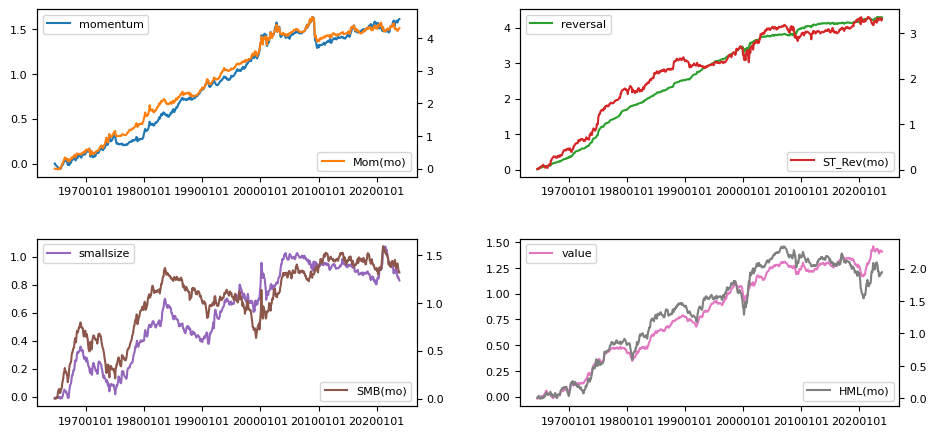

In [43]:
rebalbeg = 19640601
rebalend = LAST_DATE
rebaldates = crsp.bd.date_range(rebalbeg, rebalend, 'endmo')
loadings = dict()

# preload signal values
sf = {key: SignalsFrame(signals.read(key)) for key in ['hml', 'mom', 'strev']}

for pordate in tqdm(rebaldates):           # retrieve signal values every month
    date = bd.june_universe(pordate)
    univ = crsp.get_universe(date)
    smb = univ['capco'].rank(ascending=False).div(len(univ)).rename('smallsize')
    hml = sf['hml']('hml', date, bd.endmo(date, -12))['hml'].rename('value')
    #beta = signals('beta', pordate, bd.begmo(pordate))['beta']*2/3 + 1/3 #shrink
    mom = sf['mom']('mom', pordate)['mom'].rename('momentum')
    strev = -sf['strev']('strev', pordate)['strev'].rename('reversal')
    df = pd.concat((strev, hml, smb, mom), join='inner', axis=1)\
           .reindex(univ.index).dropna()
    loadings[pordate] = winsorize(df, quantiles=[0.05, 0.95])

# Compute coefficients from FM cross-sectional regressions
monthly = CRSPBuffer(stocks=crsp, dataset='monthly', fields=['ret'],
                     beg=bd.begmo(rebalbeg, -13), end=bd.endmo(rebalend, 1))

riskpremium = RiskPremium(sql=user, bench=bench, rf='RF', end=LAST_DATE)
out = riskpremium(stocks=monthly, loadings=loadings,
                  standardize=['value' ,'smallsize', 'momentum', 'reversal'])
     
# Compare time series of risk premiums to portfolio-sort benchmark eturns
benchnames = {'momentum': 'Mom(mo)',
              'reversal': 'ST_Rev(mo)',
              'smallsize':'SMB(mo)',
              'value': 'HML(mo)'}
out = riskpremium.fit(benchnames.values())  # to compare portfolio-sorts
riskpremium.plot(benchnames)


In [44]:
# Summarize time-series means of Fama-Macbeth risk premiums
df = out[0]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
print("Fama-MacBeth Cross-sectional Regression Risk Premiums")
df.round(4)

Fama-MacBeth Cross-sectional Regression Risk Premiums


Factor Returns,mean,stderr,std,count,tvalue,sharpe
reversal,0.0060,0.0005,0.0143,713,11.2067,1.4539
value,0.0020,0.0004,0.0112,713,4.7194,0.6123
smallsize,0.0012,0.0007,0.0179,713,1.7383,0.2255
momentum,0.0023,0.0007,0.0176,713,3.4282,0.4447


In [45]:
# Summarize time-series means of Fama-French portfolio-sort returns
df = out[2]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
print("Fama-French Portfolio-Sorts")
df.round(4)

Fama-French Portfolio-Sorts


Benchmarks,mean,stderr,std,count,tvalue,sharpe
Mom(mo),0.0060,0.0016,0.0424,713,3.8023,0.4933
ST_Rev(mo),0.0046,0.0012,0.0316,713,3.9206,0.5086
SMB(mo),0.0018,0.0011,0.0306,713,1.6111,0.2090
HML(mo),0.0027,0.0011,0.0301,713,2.4227,0.3143


In [46]:
# Show correlation of returns
print('Correlation of FM Risk Premiums and FF Portfolio-Sort Returns')
pd.concat([out[1].join(out[4]), out[4].T.join(out[3])], axis=0).round(3)

Correlation of FM Risk Premiums and FF Portfolio-Sort Returns


,reversal,value,smallsize,momentum,Mom(mo),ST_Rev(mo),SMB(mo),HML(mo)
reversal,1.000,0.008,0.078,-0.448,-0.395,0.795,0.148,0.052
value,0.008,1.000,-0.224,-0.189,-0.166,-0.021,-0.212,0.821
smallsize,0.078,-0.224,1.000,-0.004,0.132,0.006,0.524,-0.152
momentum,-0.448,-0.189,-0.004,1.000,0.885,-0.284,-0.059,-0.205
Mom(mo),-0.395,-0.166,0.132,0.885,1.000,-0.313,-0.038,-0.189
ST_Rev(mo),0.795,-0.021,0.006,-0.284,-0.313,1.000,0.184,0.012
SMB(mo),0.148,-0.212,0.524,-0.059,-0.038,0.184,1.000,-0.166
HML(mo),0.052,0.821,-0.152,-0.205,-0.189,0.012,-0.166,1.000


## Nonlinear regression

### Feature transformations

A simple way to directly extend the linear model to accommodate
non-linear relationships, using polynomial regression, is to include
transformed versions of the predictors in the model, such as a
quadratic term or several polynomial functions of the predictors, 
and use standard linear regression to estimate coefficients in order to produce a non-linear fit.  The CAPM predicts that these coefficients should be zero.

Raw polynomial terms may be highly correlated with each other: Orthogonal polynomials_ transform the raw data matrix of polynomial terms to another whose columns are a basis of orthogonal terms which span the same column space. For example, regress the second predictor on the first and replace its column with the residuals, then regress the third predictor on the first two and replace its column with the residuals, and so on.

Other feature transformation approaches include:
- dummy or binary indicator variable
- categorical variables with two or more levels
- binarization or turning a categorical variable into several binary variables (4)
- Legendre polynomals which are defined as a system of orthogonal polynomials over the interval $[-1, 1]$ 
-  interaction term constructed by computing the product of the values of the two variables to capture the effect that response of one predictor is dependent on the value of another predictor.



### Kernel regression

If there are already a large number of $k$ features, then polynomial transformations, say up to degree $d,$  may be computational expensive since we could be working in $O(k^d)$ dimensional space.  Fortunately, many high-dimensional feature mappings, denoted $\phi(x)$, correspond to kernel functions $K$, where model fitting and prediction calculations only require inner products of these kernel matrices and we never need to explicitly represent vectors in the very high-dimensional feature space.  For example, the kernel $K(x, y) = (x^Ty + c)^d$, which requires only $O(k)$ to compute, expands to the feature space corresponding with all polynomial terms up to degree $d$ of the features in $x$ and $y$. 

Kernels can be viewed as similarity metrics, that measure how close together the feature maps $\phi(x)$ and $\phi(y)$ are. The radial basis function (RBF), or Gaussian, kernel uses distance in Euclidean space which corresponds to an infinite-dimension feature mapping.

This application of Kernel functions that can be efficiently computed, where only their inner products are needed without ever explicitly computing their corresponding feature vectors in very high-dimensional space, has come to be known as the __kernel trick__.



The slight concavity of the fitted curve is consistent with the negative coefficient on observed for squared-beta factor in the Fama-MacBeth regression. The lack of monotonicity would be consistent with an insignificant coefficient for the beta factor.




/tmp/ipykernel_3511161/2598276866.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bandwidth = float((max(X_train) - min(X_train)) * 4 / len(X_train))


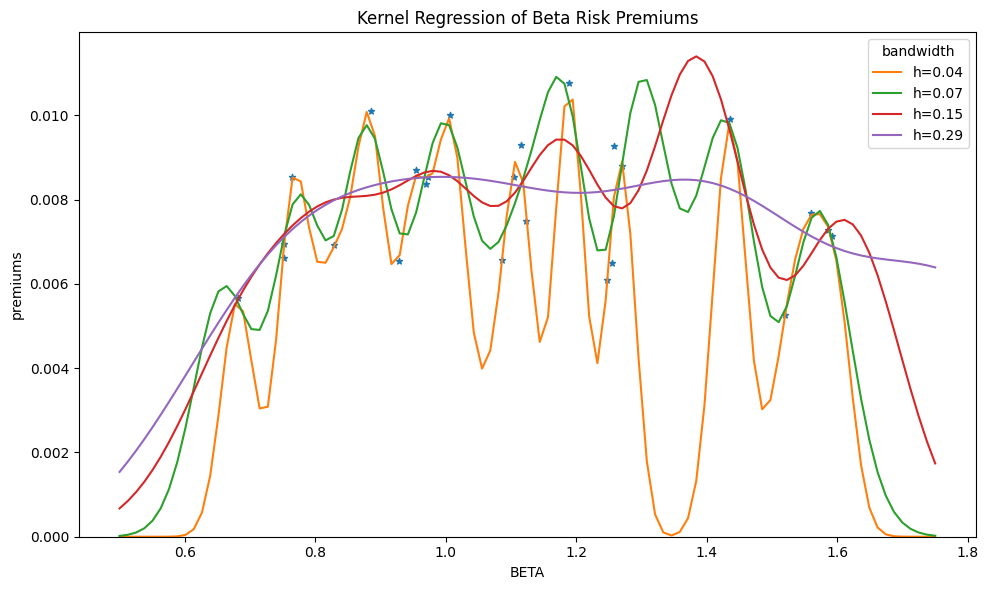

In [47]:
y_train = assets_df[['premiums']].values
X_train = assets_df[['BETA']].values
X_test = np.linspace(0.5, 1.75, 100).reshape(-1, 1)
bandwidth = float((max(X_train) - min(X_train)) * 4 / len(X_train))

fig, ax = plt.subplots(figsize=(10,6))
legend = []
color = 1
for h in [0.25, 0.5, 1, 2]:
    for alpha in [0.01]:
        model = KernelRidge(alpha=alpha, kernel='rbf', gamma=1/(h*bandwidth)**2)
        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        ax.plot(X_test, y_pred, ls='-', color=f"C{color}")
        legend.append(f"h={h*bandwidth:.2f}")
        color += 1
# scatter plot actual                                                                        
assets_df.plot(x='BETA', y='premiums', kind='scatter', ax=ax, marker="*", color="C0")
ax.set_ylim(bottom=0)
plt.legend(legend, loc='best', title='bandwidth')
plt.title('Kernel Regression of Beta Risk Premiums')
plt.tight_layout()
